In [8]:
library(tidyverse)
library(tidymodels)
library(lubridate)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [9]:
players <- read_csv("players.csv")
sessions <- read_csv("sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [10]:
glimpse(players)

Rows: 196
Columns: 7
$ experience   <chr> "Pro", "Veteran", "Veteran", "Amateur", "Regular", "Amate…
$ subscribe    <lgl> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…
$ hashedEmail  <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…
$ name         <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie", "Adrian…
$ gender       <chr> "Male", "Male", "Male", "Female", "Male", "Female", "Fema…
$ Age          <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 47, 22, 23, 17, 25, 22, 17…


## Players Data

| Attribute | Detail |
| :--- | :--- |
| **Number of rows** | 196 observations |
| **Number of columns** | 7 information |
| **Data Collection** | from the Minecraft server |

---

### Variable Names, Types, and Meanings

| Variable Name | Type | Meaning |
| :--- | :--- | :--- |
| `experience` | character | The level of experience that the user feels they have in the game minecraft (Pro, Veteran, Amateur, Regular) |
| `subscribe` | logical / boolean | yes or no if individual is already subscribed to the newsletter |
| `hashedEmail` | chr | a string of individuals emails but hash encrypted |
| `played_hours` | double/decimal | how many hours the individual has played on the server |
| `name` | chr | the name fo the individual |
| `gender` | chr | the preffered gender of the individual |
| `age` | dbl | how old the individual is |

---

### Missing Values or Inconsistencies You See

* in the last observation, there is someone named ahmed with gender as Other and no age specified. This is not very useful data and it might ruin the analysis. This could be removed so it isn't used.
* Another one for Devin, he didn't specify his age (NA) but did fill in his gender. maybe we can include this individual when comparisons for gender but not for age.

---

### Potential Issues Not Visible (e.g., bias, incomplete data)

* (This section was not explicitly detailed by the user but inferred from the previous section).

In [11]:
glimpse(sessions)

Rows: 1,535
Columns: 5
$ hashedEmail         <chr> "bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8a…
$ start_time          <chr> "30/06/2024 18:12", "17/06/2024 23:33", "25/07/202…
$ end_time            <chr> "30/06/2024 18:24", "17/06/2024 23:46", "25/07/202…
$ original_start_time <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…
$ original_end_time   <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…


## Session Data

| Attribute | Detail |
| :--- | :--- |
| **Number of rows** | 1535 observations |
| **Number of columns** | 5 information |
| **Data Collection** | from the Minecraft server |

---

### Variable Names, Types, and Meanings

| Variable Name | Type | Meaning |
| :--- | :--- | :--- |
| `hashedEmail` | chr | the email of the user who played for this session |
| `start_time` | chr | the date time of when they started played for this session |
| `end_time` | | chr: the date time of when they stopped played for this session |
| `original_start_time` | dbl | the number correspondent value of the date time they started playing for this session |
| `original_end_time` | dbl | the number correspondent value of the date time they stopped playing for this session |

---

### Missing Values or Inconsistencies You See

* there seems to be no issues. the data seems to be correct. and there is a range of sessions for different times throughout the day.

---

### Potential Issues Not Visible (e.g., bias, incomplete data)

*  maybe can change all the start_time and end_time into datetime format so when we editing or displaying the data its better.


## Demand Forecasting: Predicting Active Players

### Broad Goal

The broad goal is **demand forecasting**, namely, what time windows are most likely to have large number of simultaneous players. This is because we need to ensure that the number of licenses on hand is sufficiently large to accommodate all parallel players with high probability. **Achieving accurate demand forecasting will minimize player frustration due to capacity issues and optimize capital expenditure on server resources and licensing.**

---

### Specific Question for Analysis

**Can day of week and time of day predict the number of currently active players?**

| Component | Variable | Details |
| :--- | :--- | :--- |
| **Response Variable (Y)** | **number of active players** | The metric representing server load at any point in time. |
| **Explanatory Variables (X)** | **day of week** and **time of day** | The temporal factors hypothesized to drive player activity. |

---

### Why This Question is Important (Business Rationale)

* if we know what times there are generally more people we know which times where the server is the busiest. we can prepare for these times and buy more licenses to accomdate for these players. **This directly impacts player satisfaction and ensures a seamless experience during peak gaming periods.**
* if we know what times the server will have its heaviest load, then we can prepare the server if we need to do anything to prepare for this largest time. and then when we have the least, we could reduce the amount the server needs to save on costs. **This dynamic scaling approach maximizes cost efficiency by only running maximum capacity when necessary, directly reducing operational expenses.**
* additionally, just in case, if we know how many people there are at peak times we know the max and the minimum for liceneses on hand to be able to run all the players. **Establishing these clear maximum and minimum capacity requirements is essential for budgeting and future infrastructure planning.**

### How I will apply what we learned to find this?
* we need to do some wrangling on the data:
    * edit the session data to with a new column called: day_of_week, hour_of_day. use timestamp editing functions such as wday(), hour()
    * day_of_week can be put into a categorical factor data for each day of the week
    * time of day can be either a number (1-24) or split into categories (morning, afternoon, evening, night)
* after wrangling, group by these variables and calculate average active players per group
* Some visualisitons / plots that can be created:
    * Average players by day of week using geom_col() with x = day_of_week, y = avg_players
    * Average players by hour of day: geom_line() and geom_point() with x = hour_of_day, y = avg_players

## Question 3: Exploring

In [12]:
sessions_clean <- sessions |>
  mutate(
    start_time = dmy_hm(start_time),
    end_time = dmy_hm(end_time)
  )

sessions_clean

hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<dttm>,<dttm>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-30 18:12:00,2024-06-30 18:24:00,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-06-17 23:33:00,2024-06-17 23:46:00,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2024-07-25 17:34:00,2024-07-25 17:57:00,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2024-07-28 15:36:00,2024-07-28 15:57:00,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2024-07-25 06:15:00,2024-07-25 06:22:00,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-05-20 02:26:00,2024-05-20 02:45:00,1.71617e+12,1.71617e+12


In [13]:
players |>
  summarize(
    mean_age = mean(Age, na.rm = TRUE),
    mean_played_hours = mean(played_hours, na.rm = TRUE)
  )


mean_age,mean_played_hours
<dbl>,<dbl>
21.13918,5.845918


The average player age is around X years, and the average total play time is Y hours. This helps understand the typical player profile.

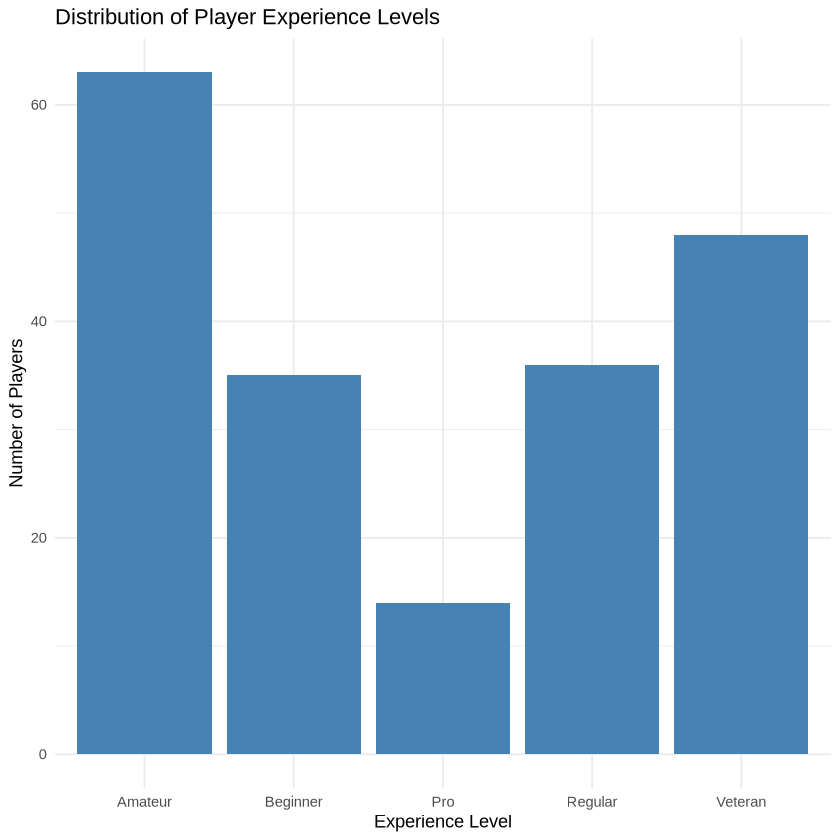

In [14]:
players |>
  ggplot(aes(x = experience)) +
  geom_bar(fill = "steelblue") +
  labs(
    title = "Distribution of Player Experience Levels",
    x = "Experience Level",
    y = "Number of Players"
  ) +
  theme_minimal()


From the graph we ca see that there is a variety of experience levels that the demographic has. There are more amaterus compared to the pros but there is a wide variety in between.

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


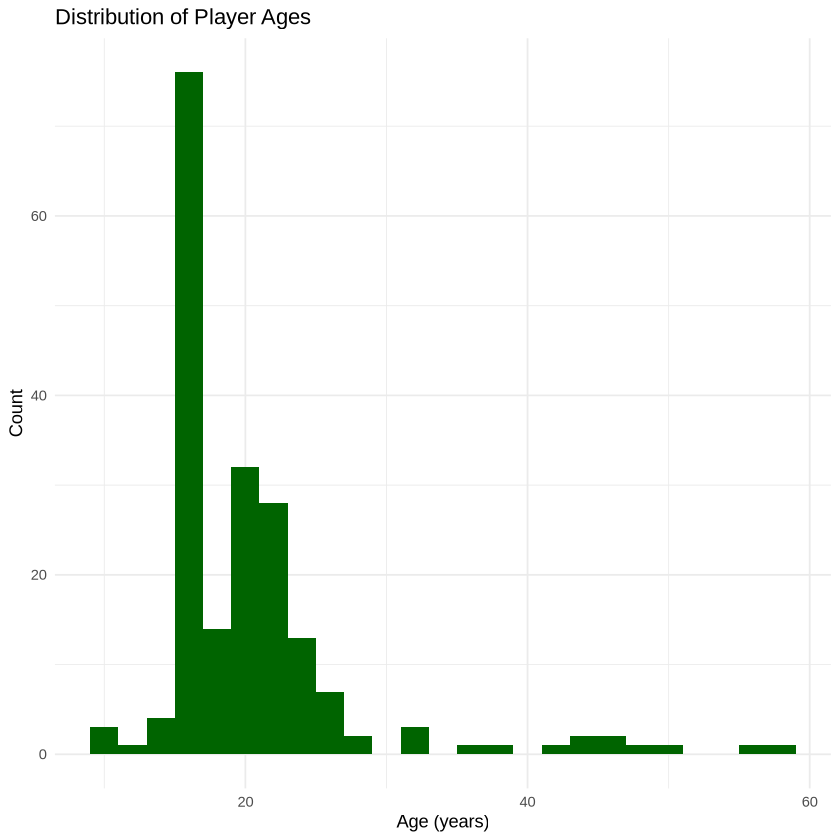

In [15]:
players |>
  ggplot(aes(x = Age)) +
  geom_histogram(binwidth = 2, fill = "darkgreen") +
  labs(
    title = "Distribution of Player Ages",
    x = "Age (years)",
    y = "Count"
  ) +
  theme_minimal()

The majority of players that are on the server are in the range of 15-25. There is a age that has the highest count which is 17 which makes sense as the server was more likely to be students from ubc, with a smaller amount of older players. Understanding the age demographic of the data allows us to see what time the players are likely to be active. Specifically, comparing students to working adults.

In [20]:
sessions_time <- sessions_clean |>
  mutate(
    day_of_week = wday(start_time, label = TRUE),
    hour_of_day = hour(start_time)
  )
sessions_time

hashedEmail,start_time,end_time,original_start_time,original_end_time,day_of_week,hour_of_day
<chr>,<dttm>,<dttm>,<dbl>,<dbl>,<ord>,<int>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-30 18:12:00,2024-06-30 18:24:00,1.71977e+12,1.71977e+12,Sun,18
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-06-17 23:33:00,2024-06-17 23:46:00,1.71867e+12,1.71867e+12,Mon,23
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2024-07-25 17:34:00,2024-07-25 17:57:00,1.72193e+12,1.72193e+12,Thu,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2024-07-28 15:36:00,2024-07-28 15:57:00,1.72218e+12,1.72218e+12,Sun,15
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2024-07-25 06:15:00,2024-07-25 06:22:00,1.72189e+12,1.72189e+12,Thu,6
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-05-20 02:26:00,2024-05-20 02:45:00,1.71617e+12,1.71617e+12,Mon,2


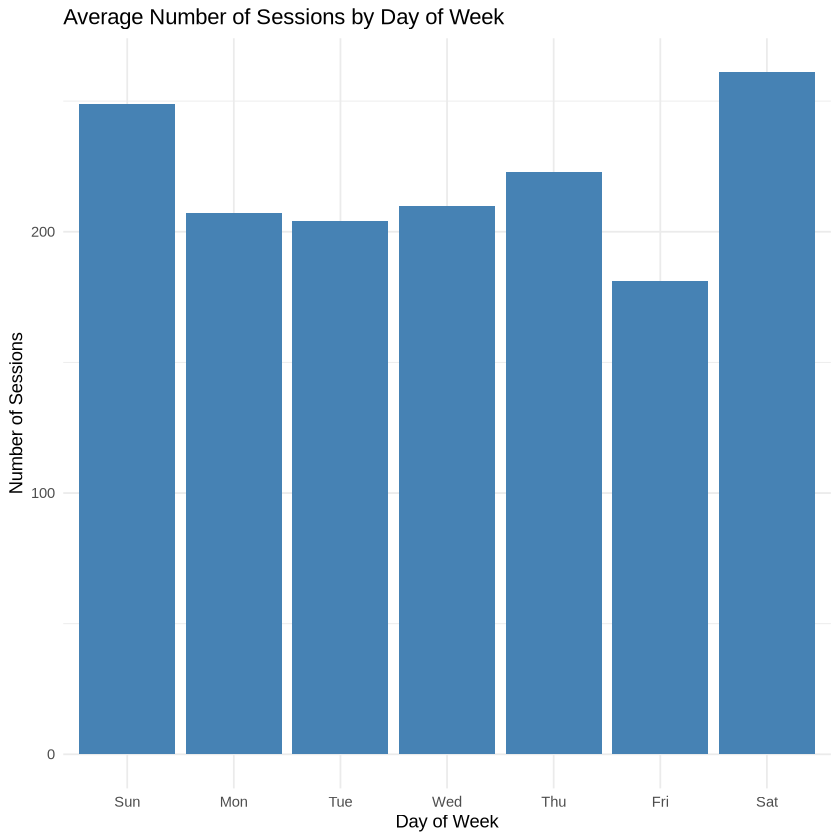

In [21]:
sessions_time |>
  group_by(day_of_week) |>
  summarize(avg_sessions = n()) |>
  ggplot(aes(x = day_of_week, y = avg_sessions)) +
  geom_col(fill = "steelblue") +
  labs(
    title = "Average Number of Sessions by Day of Week",
    x = "Day of Week",
    y = "Number of Sessions"
  ) +
  theme_minimal()


From the general observation, we see that there is alot of sessions per day. But there are a clear differnence in sessions on saturday and sunday. 

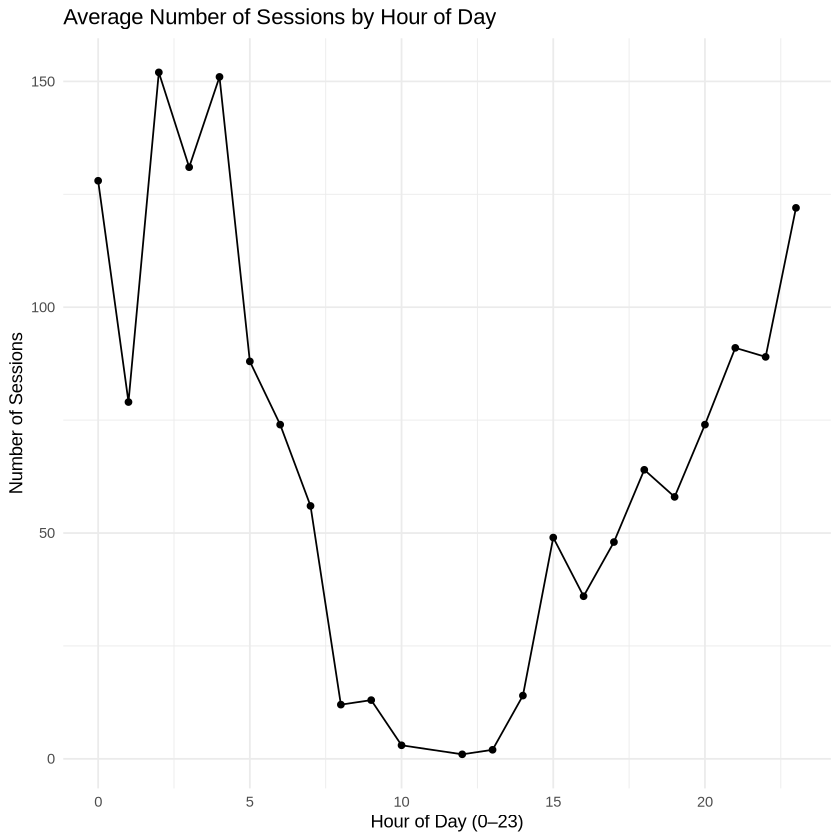

In [22]:
sessions_time |>
  group_by(hour_of_day) |>
  summarize(avg_sessions = n()) |>
  ggplot(aes(x = hour_of_day, y = avg_sessions)) +
  geom_line() +
  geom_point() +
  labs(
    title = "Average Number of Sessions by Hour of Day",
    x = "Hour of Day (0–23)",
    y = "Number of Sessions"
  ) +
  theme_minimal()


### Methods and Plan

Method Chosen: K-Nearest Neighbours (KNN) Regression

Question: "Can day of week and time of day predict the number of active players?

Why I chose KNN Regression:
* The goal is to predict a numerical value (the currently active player count), and KNN can be used for numeric prediction
* This model is designed for non-linear relationships, where there is no clear linear pattern, which is what the data is most likely to be. An example could be alot more people suddenly playing in the evening or during saturday or sunday.

Assumptions Made:
* Players active at similiar times (same hour or days) should reuslt in similiar activity levels
* Distance between points should matter similiarly
* Data must be normalized/scaled later on to prevent one variable overpowering the other

Potential limitations:
* The KNN model can become slow if the data is large. However, as this data set is relatively small (approximately 1500 sessions), it shouldn't be much of an issue.
* Using KNN can result in unncessary noise or sensitivity to irrelevant variables. This can reduce the accuracy of the outcome. To prevent this, ensure to carefully wrangle the data before using it to model.

How to Compare and Select the Best Model:
* Use cross-validation to choose the optimal value of K
    * Create a grid of possible K values (e.g. 1, 5, 20)
    * Evaluate the accuracy from its resultant RMSE
    * Selecting the K that has the least RMSE on unseen daata
* By applying these steps, the model should work for unseen data generalising it well and avoiding overfitting.

How to Process the Data for Modeling:
1. Wrangling
    * Convert session start times to numerical values:
        * hour_of_day: (0-24)
        * day_of_week: (1-7)
    * Calculate number of active players per time window
    * Normalize the data before fitting the model
2. Splitting the model
    * Split the ratio to 70/30:
        * Training: 70%
        * Testing: 30%
3. Cross Validation
    * Perform a 5-fold cross valodation using the training set
    * Choose the best K value with the lowest RMSE
4. Fit the model
    * Train the model using the best K value on the entire training set
5. Evaluation:
    * Apply model to test data
    * Evaluate performance using test data only and see if the model fits well